In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load
-check for nulls
-check for outliers

In [218]:
df = pd.read_csv('../data/heart_2020.csv')

In [219]:
df.shape

(319795, 18)

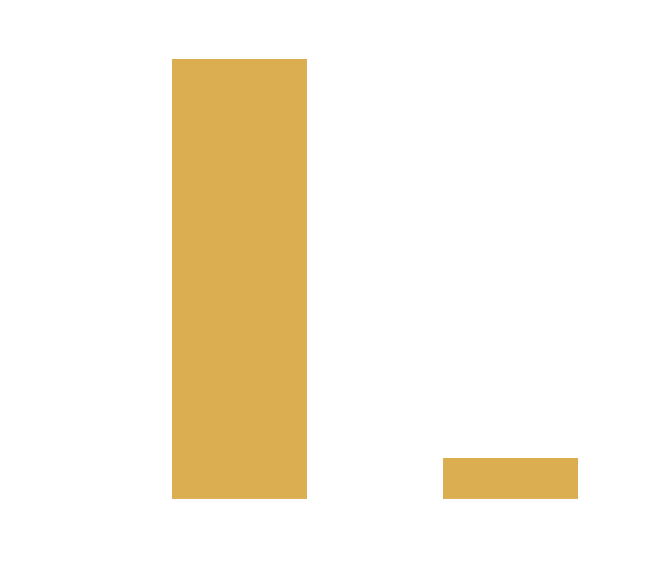

In [254]:
fig, ax = plt.subplots(figsize =(7,6))
df['HeartDisease'].value_counts().plot(kind='bar', color = '#dcae52', ax=ax)
ax.set_title('Count Before Over Sampling', color='white')
ax.set_xlabel('Answers', color = 'white',fontsize =15)
ax.set_ylabel('Count', color = 'white', fontsize=15 )
ax.tick_params(axis='x', colors='white', labelsize=11)
ax.tick_params(axis='y', colors='white', labelsize=11)
ax.spines['left'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['bottom'].set_color('white')
plt.savefig('../images/count_tp',bbox_inches='tight', transparent=True)
plt.show()

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [121]:
df.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

array([[<Axes: title={'center': 'BMI'}>,
        <Axes: title={'center': 'PhysicalHealth'}>],
       [<Axes: title={'center': 'MentalHealth'}>,
        <Axes: title={'center': 'SleepTime'}>]], dtype=object)

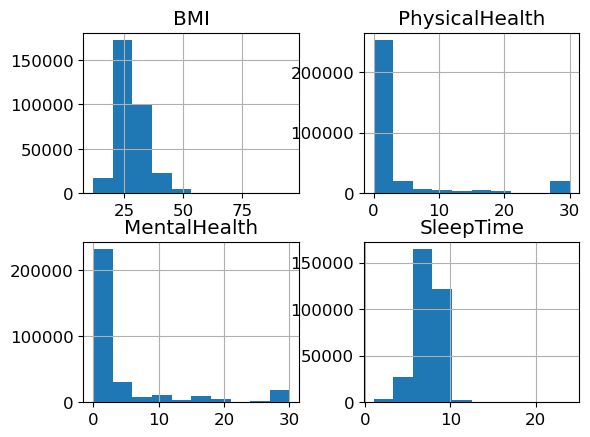

In [122]:
df.hist()

In [123]:
df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


In [124]:
df[df['MentalHealth']==30]['HeartDisease'].value_counts()

No     15086
Yes     2287
Name: HeartDisease, dtype: int64

In [125]:
df[df['BMI']>47]['HeartDisease'].value_counts()

No     3834
Yes     507
Name: HeartDisease, dtype: int64

In [126]:
df.drop(df[df['SleepTime']>10].index, inplace=True)

In [127]:
df.drop(df[df['BMI']>47].index,inplace=True)

## Imbalanced dataset

In [128]:
df['HeartDisease'].value_counts()

No     285706
Yes     26230
Name: HeartDisease, dtype: int64

## Create dummy variables for categorical data

In [129]:
cat_cols = df.select_dtypes(include='object').columns
cat_cols

Index(['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
       'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity',
       'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

In [130]:
df2 = pd.get_dummies(df,cat_cols,drop_first=True)

In [131]:
X = df2.loc[:,df2.columns!='HeartDisease_Yes']
y = df2['HeartDisease_Yes']

## Handling imbalance
- first we split our data into test and train set. When we resample a dataset we don't want to affect the testing data.
- using a random over sampler we resample the training data

In [132]:
from sklearn.model_selection import train_test_split


In [133]:
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size=.30, random_state= 42)

In [134]:
from imblearn.over_sampling import RandomOverSampler

In [135]:
rs = RandomOverSampler(sampling_strategy=.7, random_state=42,)

In [136]:
X_train_rs, y_train_rs = rs.fit_resample(X_train,y_train)

In [137]:
y_train_rs.value_counts()

0    200079
1    140055
Name: HeartDisease_Yes, dtype: int64

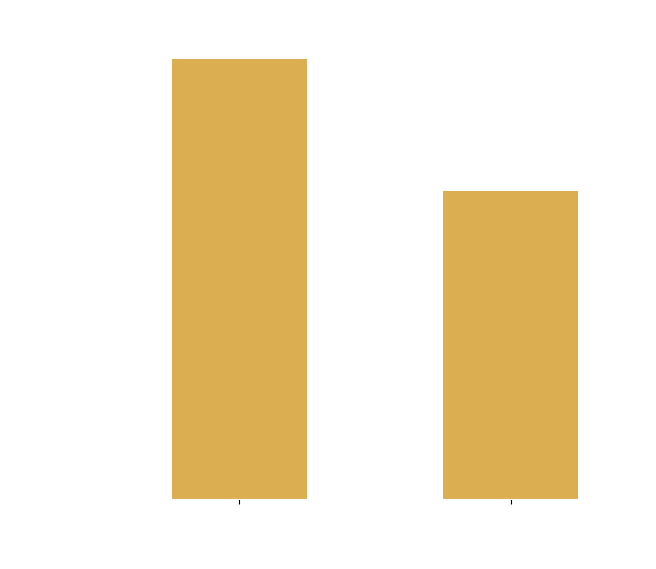

In [253]:
fig, ax = plt.subplots(figsize=(7,6))
y_train_rs.value_counts().plot(kind='bar', color = '#dcae52', ax=ax)
ax.set_title('Count After Over Sampling', color='white')
ax.set_xlabel('Answers', color = 'white',fontsize =15)
ax.set_ylabel('Count', color = 'white', fontsize=15 )
ax.set_xticklabels(['No','Yes'], color='white', fontsize=11)
ax.tick_params(axis='y', colors='white', labelsize=11)
ax.spines['left'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['bottom'].set_color('white')
plt.savefig('../images/count_resample_tp',bbox_inches='tight', transparent=True)
plt.show()

In [138]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.metrics import roc_curve,roc_auc_score


# Creating a dictionary of classifiers
-We want to compare which classifier can best predict heart disease
-in the dict we initialize our classifiers
-the "params" is a dictionary with the hyperparmeters as a key and the values we want to test are a list

In [139]:
algos = {
    'Decision_Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'splitter': ['best'],
            'max_features': ['sqrt','log2'],
            'random_state': [42]
        }
    },
    'Random_Forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'n_estimators': [150,250],
            'random_state': [42],
            'max_depth': [30,50],
            'max_features': ['sqrt'],
            'min_samples_leaf': [1,2],
            'max_leaf_nodes': [None,8,16]
        }
    },
    'Logistic_Regression' :{
        'model' : LogisticRegression(),
        'params' : {
            'max_iter': [100,200],
            'random_state': [42],

        }
    },
    'Gradient_Boosting' :{
        'model' : GradientBoostingClassifier(),
        'params' : {
            'learning_rate': [.1,.25,],
            'n_estimators': [600],
            'random_state': [42],
            'n_iter_no_change': [10],
            'max_features': ['sqrt',],
        }
    }

}

-We iterate through our dict and using gridsearchcv test all configurations of our classifiers
-We then create a dataframe with the classifier and the best score they received during cross-validation

In [140]:
scores = []
models ={}
for algo_name, config in algos.items():
    gs =  GridSearchCV(config['model'], config['params'], cv=3,
          return_train_score=False, n_jobs=-1, scoring='roc_auc',)
    gs.fit(X_train_rs,y_train_rs)
    scores.append({
        'model': algo_name,
        'best_score': gs.best_score_,
        'best_params': gs.best_params_
    })
    models[algo_name] = gs
pd.DataFrame(scores,columns=['model','best_score','best_params'])



C:\Users\shane\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model,best_score,best_params
0,Decision_Tree,0.951680,"{'max_features': 'sqrt', 'random_state': 42, '..."
1,Random_Forest,0.996306,"{'max_depth': 50, 'max_features': 'sqrt', 'max..."
2,Logistic_Regression,0.839347,"{'max_iter': 200, 'random_state': 42}"
3,Gradient_Boosting,0.848736,"{'learning_rate': 0.25, 'max_features': 'sqrt'..."


In [141]:
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# Create ROC Curve

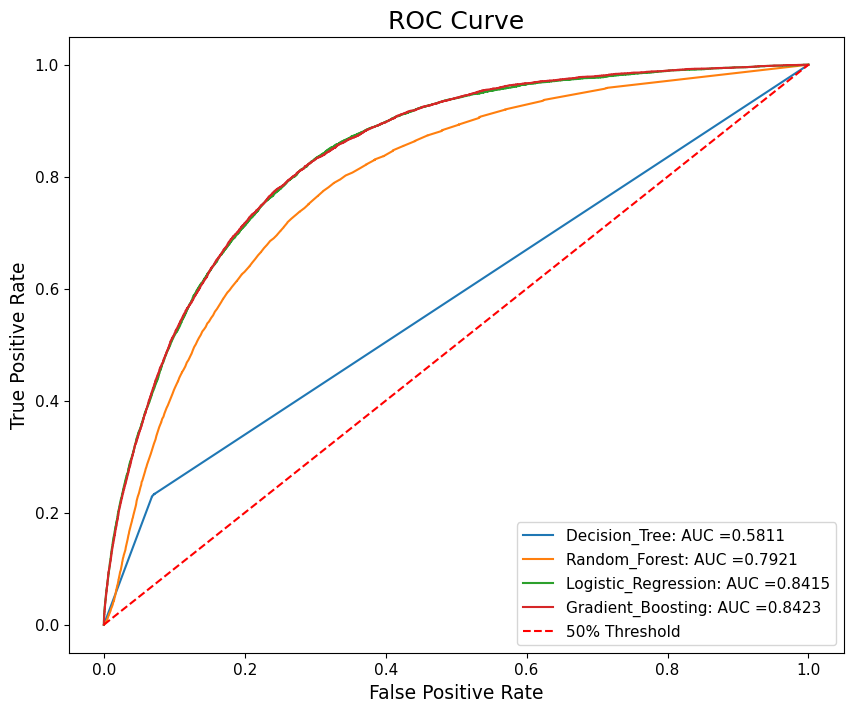

In [257]:
fig, ax = plt.subplots(figsize = (10,8))
for algo_name ,model in models.items():
    y_pred_proab = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,y_pred_proab)
    auc = roc_auc_score(y_test,y_pred_proab)
    ax.plot(fpr,tpr, label = f'{algo_name}: AUC ={round(auc,4)}')
ax.plot([0,1],[0,1], c='red', linestyle='dashed',label='50% Threshold')
# ax.spines['left'].set_color('white')
# ax.spines['top'].set_color('white')
# ax.spines['right'].set_color('white')
# ax.spines['bottom'].set_color('white')
plt.ylabel('True Positive Rate', fontsize =13.5,)
plt.xlabel('False Positive Rate', fontsize =13.5,)
plt.legend(loc=4, fontsize =11)
plt.yticks(fontsize=11,)
plt.xticks(fontsize=11,)
plt.title('ROC Curve', )
# plt.savefig('../images/Roc_curve_tp',bbox_inches='tight',transparent=True)
# plt.savefig('../images/Roc_curve',bbox_inches='tight')
plt.show()

In [143]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [144]:
for algo_name ,model in models.items():
    y_pred = model.predict(X_test)
    print(algo_name)
    print('--------------------------------------------------------')
    print(classification_report(y_test,y_pred))


Decision_Tree
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     85627
           1       0.23      0.23      0.23      7954

    accuracy                           0.87     93581
   macro avg       0.58      0.58      0.58     93581
weighted avg       0.87      0.87      0.87     93581

Random_Forest
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     85627
           1       0.31      0.22      0.26      7954

    accuracy                           0.89     93581
   macro avg       0.62      0.59      0.60     93581
weighted avg       0.88      0.89      0.88     93581

Logistic_Regression
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.82      0.89     85627
           1      

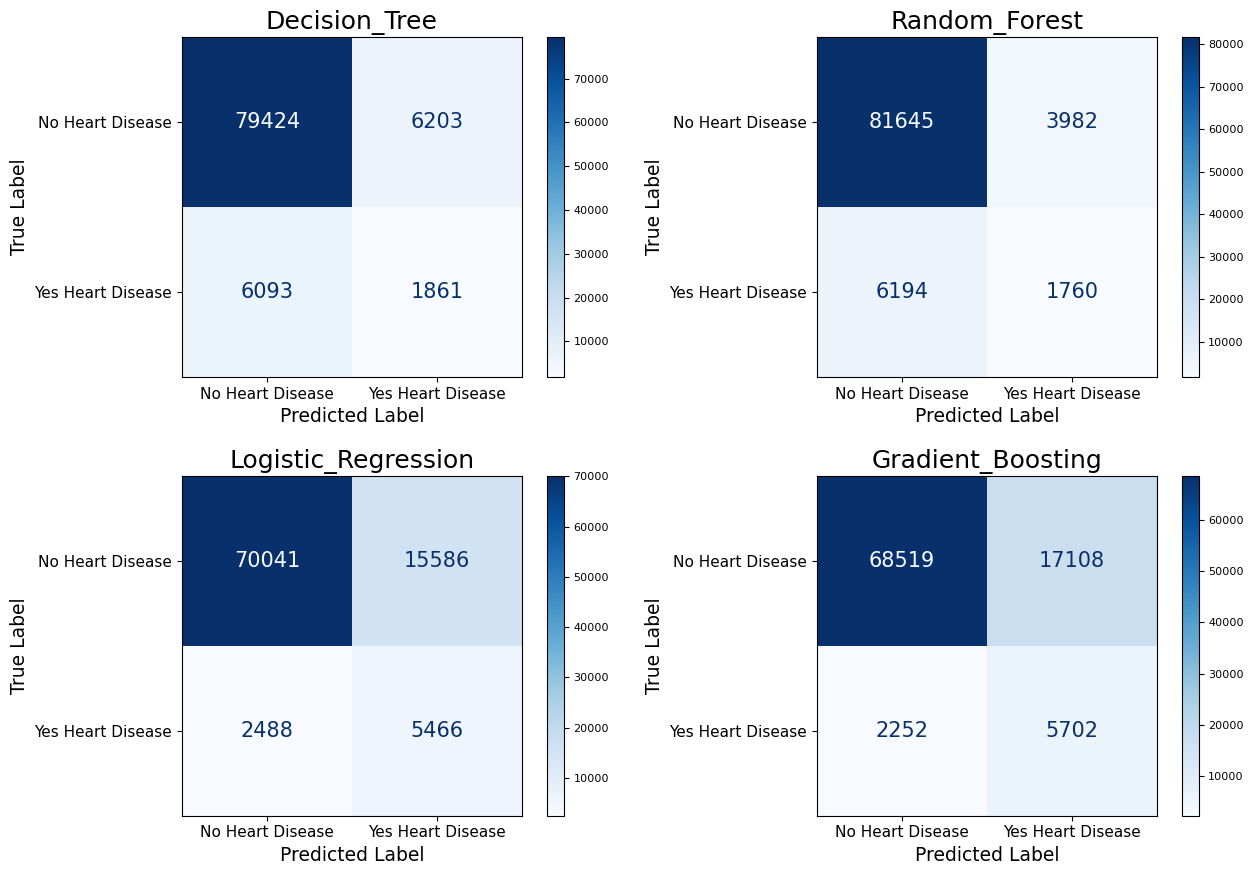

In [265]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13,9))
plt.rcParams.update({'font.size': 15})
for cls, ax , algo_name in zip(models.values(), axes.flatten(),models.keys()):
    ConfusionMatrixDisplay.from_estimator(cls,X_test,y_test,ax=ax, cmap='Blues', display_labels=['No Heart Disease','Yes Heart Disease'], values_format='d')
    ax.set_title(algo_name,)
    ax.set_xlabel('Predicted Label', fontsize = 13.5,)
    ax.set_ylabel('True Label', fontsize = 13.5,)
    ax.set_xticklabels(['No Heart Disease','Yes Heart Disease'],fontsize=11,)
    ax.set_yticklabels(['No Heart Disease','Yes Heart Disease'],fontsize=11,)
plt.tight_layout()
plt.savefig('../images/confusion_matrix_heart.png',bbox_inches='tight',facecolor ='#dcae52')
plt.show()